# Log Anomaly Detection with Isolation Forests
This notebook detects anomalies in log data using Isolation Forests.

In [19]:

import pandas as pd

# Load dataset
file_path = './Linux_2k.log_structured.csv'
df = pd.read_csv(file_path)
df.head()


,LineId,Month,Date,Time,Level,Component,PID,Content,EventId,EventTemplate
0,1,Jun,14,15:16:01,combo,sshd(pam_unix),19939.0,authentication failure; logname= uid=0 euid=0 ...,E16,authentication failure; logname= uid=0 euid=0 ...
1,2,Jun,14,15:16:02,combo,sshd(pam_unix),19937.0,check pass; user unknown,E27,check pass; user unknown
2,3,Jun,14,15:16:02,combo,sshd(pam_unix),19937.0,authentication failure; logname= uid=0 euid=0 ...,E16,authentication failure; logname= uid=0 euid=0 ...
3,4,Jun,15,02:04:59,combo,sshd(pam_unix),20882.0,authentication failure; logname= uid=0 euid=0 ...,E18,authentication failure; logname= uid=0 euid=0 ...
4,5,Jun,15,02:04:59,combo,sshd(pam_unix),20884.0,authentication failure; logname= uid=0 euid=0 ...,E18,authentication failure; logname= uid=0 euid=0 ...


## Preprocessing: Convert Text to Numerical Features

In [20]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Convert EventId into numerical labels
label_encoder = LabelEncoder()
df["EventId_encoded"] = label_encoder.fit_transform(df["EventId"])

# TF-IDF vectorization of log content
vectorizer = TfidfVectorizer(max_features=500)  
tfidf_matrix = vectorizer.fit_transform(df["Content"])

# Combine encoded EventId and TF-IDF features
X = np.hstack((df["EventId_encoded"].values.reshape(-1, 1), tfidf_matrix.toarray()))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape


(2000, 501)

## Apply Isolation Forests for Anomaly Detection

In [22]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.10, random_state=42)
df["Anomaly"] = iso_forest.fit_predict(X_scaled)

# Isolation Forest labels anomalies as -1, normal points as 1
num_anomalies = (df["Anomaly"] == -1).sum()
num_anomalies

194

## Visualizing Anomalies

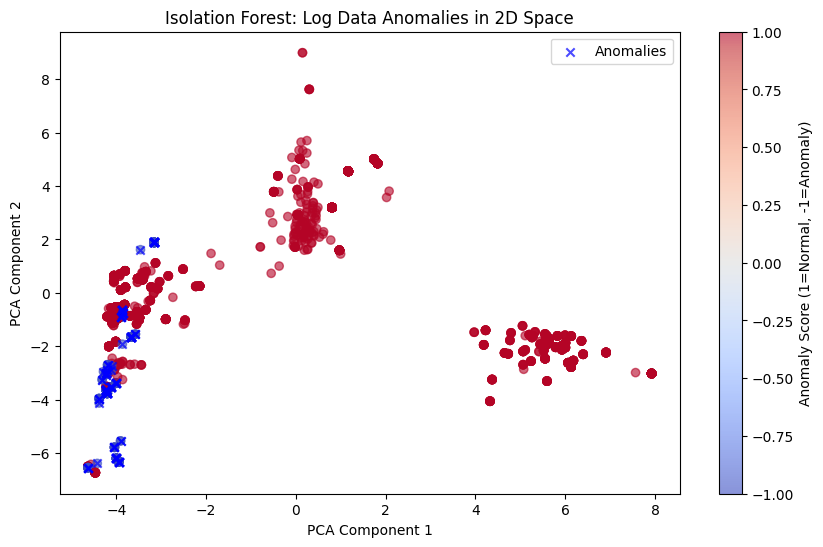

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA coordinates
df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

# Scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df["PCA1"], df["PCA2"], c=df["Anomaly"], cmap="coolwarm", alpha=0.6)
plt.colorbar(scatter, label="Anomaly Score (1=Normal, -1=Anomaly)")
plt.scatter(df[df["Anomaly"] == -1]["PCA1"], df[df["Anomaly"] == -1]["PCA2"], 
            color="blue", marker="x", label="Anomalies", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Isolation Forest: Log Data Anomalies in 2D Space")
plt.legend()
plt.show()


## Extracting Anomaly Patterns

In [14]:

from collections import Counter
import itertools

# Extract anomalies
anomalies_df = df[df["Anomaly"] == -1]

# Count frequent anomalous EventIds
anomalous_event_counts = anomalies_df["EventId"].value_counts().head(10)

# Common keywords in anomaly logs
words = list(itertools.chain(*[content.split() for content in anomalies_df["Content"]]))
common_keywords = Counter(words).most_common(15)

anomalous_event_counts, common_keywords


(EventId
 E29    194
 Name: count, dtype: int64,
 [('connection', 194),
  ('from', 194),
  ('at', 194),
  ('2005', 194),
  ('Jul', 149),
  ('Sun', 126),
  ('17', 87),
  ('()', 47),
  ('203.101.45.59', 46),
  ('(dsl-Chn-static-059.45.101.203.touchtelindia.net)', 46),
  ('Jun', 45),
  ('Sat', 38),
  ('83.116.207.11', 32),
  ('(aml-sfh-3310b.adsl.wanadoo.nl)', 32),
  ('61.74.96.178', 23)])

## Save Detected Anomalies

In [15]:

# Save anomalies to CSV
anomalies_df[["LineId", "EventId", "Content"]].to_csv("./anomalies_detected.csv", index=False)
"./anomalies_detected.csv"


'./anomalies_detected.csv'

## Analyze Anomalous Events

In [16]:
import re

# Load anomalies file
file_path = "anomalies_detected.csv"
df = pd.read_csv(file_path)

# Count most frequent anomalous EventIds
event_counts = df["EventId"].value_counts().head(10)
print("Most Frequent Anomalous Events:")
print(event_counts)
print("\n" + "="*50 + "\n")

# Extract words from Content column
words = list(itertools.chain(*[content.split() for content in df["Content"]]))
common_keywords = Counter(words).most_common(15)
print("Common Keywords in Anomalies:")
print(common_keywords)
print("\n" + "="*50 + "\n")

# Detect IP addresses in Content
ip_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
ip_addresses = list(itertools.chain(*[re.findall(ip_pattern, content) for content in df["Content"]]))
ip_counts = Counter(ip_addresses).most_common(10)
print("Most Frequent IP Addresses in Anomalies:")
print(ip_counts)


Most Frequent Anomalous Events:
EventId
E29    194
Name: count, dtype: int64


Common Keywords in Anomalies:
[('connection', 194), ('from', 194), ('at', 194), ('2005', 194), ('Jul', 149), ('Sun', 126), ('17', 87), ('()', 47), ('203.101.45.59', 46), ('(dsl-Chn-static-059.45.101.203.touchtelindia.net)', 46), ('Jun', 45), ('Sat', 38), ('83.116.207.11', 32), ('(aml-sfh-3310b.adsl.wanadoo.nl)', 32), ('61.74.96.178', 23)]


Most Frequent IP Addresses in Anomalies:
[('203.101.45.59', 46), ('059.45.101.203', 46), ('83.116.207.11', 32), ('61.74.96.178', 23), ('82.83.227.67', 23), ('212.65.68.82', 23), ('82.252.162.81', 22), ('207.30.238.8', 17), ('82.68.222.194', 6), ('218.146.61.230', 1)]
